In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
features=pd.read_csv("https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/random_forest_explained/data/temps_extended.csv", sep=',')

In [4]:
features.head()

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


We are trying to predict the temperature tomorrow in our city (Seattle, WA) using past historical weather data. We have 4.5 years of training data, 1.5 years of test data, and are using 6 different features (variables) to make our predictions. This is a regression problem

In [6]:
features.isnull().sum() #there are no null values

year       0
month      0
day        0
weekday    0
ws_1       0
prcp_1     0
snwd_1     0
temp_2     0
temp_1     0
average    0
actual     0
friend     0
dtype: int64

In [7]:
#One hot encoding
features=pd.get_dummies(features)

#Extract Features and labels
labels=features['actual']
features.drop(['actual'], axis=1, inplace=True)

# Restrict to most imortant features 
Names of six features accounting for 95% of total importance from other notebook. here we are only concentrating on hyperparameter tuning

In [9]:
important_feature_names=['temp_1', 'average', 'ws_1', 'temp_2', 'friend', 'year']

#Update feature list
feature_list=important_feature_names
features=features[important_feature_names]
features.head()

,temp_1,average,ws_1,temp_2,friend,year
0,37,45.6,4.92,36,40,2011
1,40,45.7,5.37,37,50,2011
2,39,45.8,6.26,40,42,2011
3,42,45.9,5.59,39,59,2011
4,38,46.0,3.80,42,39,2011


In [11]:
labels.head() #Our dependent variable

0    40
1    39
2    42
3    38
4    45
Name: actual, dtype: int64

In [13]:
# Convert to numpy arrays
features=np.array(features)
labels=np.array(labels)

#Training and testing sets

train_features, test_features, train_labels, test_labels=train_test_split(features, labels, test_size=0.25, random_state=42)

In [16]:
print("training Feature Shape", train_features.shape)
print("training labels shape", train_labels.shape)
print("testing feature shape", test_features.shape)
print("testing labels shape", test_labels.shape)

training Feature Shape (1643, 6)
training labels shape (1643,)
testing feature shape (548, 6)
testing labels shape (548,)


In [19]:
print('{:0.1f} years of data in the training set'.format(train_features.shape[0] / 365.))
print('{:0.1f} years of data in the test set'.format(test_features.shape[0] / 365.))

4.5 years of data in the training set
1.5 years of data in the test set


# Examine default Random Forest to determine Parameters

In [22]:
rf=RandomForestRegressor()
#Look at the parameters used in current forest
#print(rf.get_params())


from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


# Random Search with Cross Validation

In [24]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [25]:
# Use the random grid to search for the best hyperparameter
# First create a base model to tune
rf=RandomForestRegressor(n_estimators=42)
# Random Search of parameters using 3 fold cross validation
# Search across 100 different combinations and use all the cores
rf_random=RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, scoring='neg_mean_absolute_error', cv=3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

In [26]:
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=42, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=2)

In [27]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [28]:
rf_random.cv_results_

{'mean_fit_time': array([  1.95387952,   8.56593084,   6.90593179,  18.16265909,
          7.18538245,   4.49259289,   6.81897958,   4.64868919,
         13.47595096,  17.21290143,   2.72993692,   5.59937723,
         10.22136362,   8.70080161,   4.47653786,  16.09785668,
          6.01080561,   4.81962172,  19.18403109,   5.30677438,
          9.13125141,   8.99670966,   5.79358514,  12.32644852,
          7.8314352 ,   2.35131868,  19.18495226,   5.12867117,
         16.47022502,   5.27131017,   5.3495992 ,   4.05067706,
          4.90652013,   3.44702387,   7.29881501,   4.22391097,
          5.1933554 ,   6.35535542,   5.9239374 ,   4.82889771,
          1.02774398,   2.07147821,   2.9393146 ,   1.46882391,
          1.79097303,   6.09717107,  13.25639947,   1.58775584,
          5.42921933,   3.758178  ,  21.2284979 ,  17.13117854,
          8.25793187,   8.5157845 ,   7.87215281,   2.64548182,
         11.12961841,  12.54580712,  11.5923543 ,   5.36792167,
          0.98943162,  

# Evaluation Function


In [29]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Evaluate the Default Model

In [30]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

Model Performance
Average Error: 3.9199 degrees.
Accuracy = 93.36%.


## Evaluate the Best Random Search Model

In [31]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

Model Performance
Average Error: 3.7280 degrees.
Accuracy = 93.71%.


In [32]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.38%.


# Grid Search

We can now perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search.

In [34]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

 #Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [35]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  6.8min finished


In [36]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

## Evaluate the Best Model from Grid Search

In [37]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Model Performance
Average Error: 3.6561 degrees.
Accuracy = 93.83%.


In [38]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.50%.


# Another Round of Grid Search



In [39]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   22.0s finished


In [40]:
grid_search_final.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 100}

In [41]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

Model Performance
Average Error: 3.6602 degrees.
Accuracy = 93.82%.


In [42]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_final_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.49%.




A very slight improvement in accuracy means we have reached the point of diminishing returns from tuning. We will stop here and use this as our final model.

# Final Model
The final model from hyperparameter tuning is as follows.

In [43]:
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, test_features, test_labels)

Final Model Parameters:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 80,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 3.6561 degrees.
Accuracy = 93.83%.


# Comparison of All Improvement Techniques
Finally, we can make comparisons between the improvement techniques to determine which ones were most effective.

In [44]:
import time

In [45]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        predictions.append(model.predict(x_test))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

# Baseline (Historical Average)

In [47]:
full_features = pd.read_csv("https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/random_forest_explained/data/temps_extended.csv", sep=',')
full_features = full_features.rename(columns = {'weekday': 'week'})
full_features = pd.get_dummies(full_features)

full_labels = full_features['actual']
full_features = full_features.drop('actual', axis = 1)

full_feature_list = list(full_features.columns)
important_feature_names = ['temp_1', 'average', 'ws_1', 'temp_2', 'friend', 'year']

full_features_train, full_features_test, full_labels_train, full_labels_test = train_test_split(full_features, full_labels, 
                                                                                                test_size = 0.25, random_state = 42)

baseline_preds = full_features_test['average']
baseline_errors = abs(baseline_preds - full_labels_test)
baseline_mean_error = np.mean(baseline_errors)
baseline_accuracy = 100 - (100 * np.mean(baseline_errors / full_labels_test))

In [48]:
baseline_results = {'model': 'average', 'time': np.nan, 'n_trees': np.nan, 'error': baseline_mean_error, 'accuracy': baseline_accuracy, 'n_features': 1}

# Model with One Year of Data

In [51]:
original_features = pd.read_csv("https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/random_forest_explained/data/temps.csv", sep=',')
original_features = pd.get_dummies(original_features)

original_labels = np.array(original_features['actual'])
original_features= original_features.drop('actual', axis = 1)

original_feature_list = list(original_features.columns)
original_features = np.array(original_features)

original_train_features, original_test_features, original_train_labels, original_test_labels = train_test_split(original_features, original_labels, test_size = 0.25, random_state = 42)

# Need to keep only those features the one year model was trained on
one_test_features = full_features_test[original_feature_list]
one_test_features = np.array(one_test_features)

full_labels_test = np.array(full_labels_test)

# Default model
rf = RandomForestRegressor(n_estimators= 10, random_state=42)

# Results for model trained on one year of data
one_year_results = evaluate_model(rf, original_train_features, original_train_labels, one_test_features, full_labels_test)
one_year_results['model'] = 'one_year'

In [52]:
one_year_results

{'accuracy': 92.46787090636289,
 'error': 4.3385036496350367,
 'model': 'one_year',
 'n_features': 14,
 'n_trees': 10,
 'time': 0.079355716705322266}

# Model with 4.5 Years of Training Data and All Features

In [53]:
full_features_train = np.array(full_features_train)
full_features_test = np.array(full_features_test)
full_labels_train = np.array(full_labels_train)
full_labels_test = np.array(full_labels_test)

In [54]:
four_year_results = evaluate_model(rf, full_features_train, full_labels_train, full_features_test, full_labels_test)
four_year_results['model'] = 'four_years_all'

In [55]:


four_year_results



{'accuracy': 93.508882061150615,
 'error': 3.8368613138686136,
 'model': 'four_years_all',
 'n_features': 17,
 'n_trees': 10,
 'time': 0.11867353916168213}

# Model with 4.5 Years of Training Data and Most Important Features

In [56]:
important_feature_indices = [full_feature_list.index(feature) for feature in important_feature_names]

In [57]:
train_features = full_features_train[:, important_feature_indices]
test_features = full_features_test[:, important_feature_indices]

train_labels = full_labels_train[:]
test_labels = full_labels_test[:]

In [58]:
four_years_important_results = evaluate_model(rf, train_features, train_labels, test_features, test_labels)
four_years_important_results['model'] = 'four_years_red'

In [59]:
four_years_important_results

{'accuracy': 93.359031272002653,
 'error': 3.9198905109489051,
 'model': 'four_years_red',
 'n_features': 6,
 'n_trees': 10,
 'time': 0.081251859664916992}

# Random Search Best Model

In [60]:
random_results = evaluate_model(best_random, train_features, train_labels, test_features, test_labels)

In [61]:
random_results['model'] = 'best_random'

In [62]:
random_results

{'accuracy': 93.719786990123055,
 'error': 3.7241645631574194,
 'model': 'best_random',
 'n_features': 6,
 'n_trees': 400,
 'time': 1.8980426788330078}

# First Grid Search Best Model

In [63]:
first_grid_results = evaluate_model(best_grid, train_features, train_labels, test_features, test_labels)
first_grid_results['model'] = 'first_grid'

In [64]:
first_grid_results

{'accuracy': 93.829750019973275,
 'error': 3.6561191924832999,
 'model': 'first_grid',
 'n_features': 6,
 'n_trees': 100,
 'time': 0.31044423580169678}

# Second Grid Search Best Model

In [65]:
final_model_results = evaluate_model(best_grid_final, train_features, train_labels, test_features, test_labels)
final_model_results['model'] = 'second_grid'

In [66]:
final_model_results

{'accuracy': 93.815667489656249,
 'error': 3.660153687961988,
 'model': 'second_grid',
 'n_features': 6,
 'n_trees': 100,
 'time': 0.29824271202087405}

# Comparison

In [67]:
comparison = {'model': [baseline_results['model'], one_year_results['model']],
              'accuracy': [round(baseline_results['accuracy'], 3), round(one_year_results['accuracy'], 3)],
              'error': [round(baseline_results['error'], 3), round(one_year_results['error'], 3)],
              'n_features': [baseline_results['n_features'], one_year_results['n_features']],
              'n_trees': [baseline_results['n_trees'], int(one_year_results['n_trees'])],
              'time': [round(baseline_results['time'], 4), round(one_year_results['time'], 4)]}
                        
for model in [four_year_results, four_years_important_results, random_results, first_grid_results, final_model_results]:
    comparison['accuracy'].append(round(model['accuracy'], 3))
    comparison['error'].append(round(model['error'], 3))
    comparison['model'].append(model['model'])
    comparison['n_features'].append(model['n_features'])
    comparison['n_trees'].append(int(model['n_trees']))
    comparison['time'].append(round(model['time'], 4))

In [68]:
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')

In [69]:
comparison[['model', 'accuracy', 'error', 'n_features', 'n_trees', 'time']]

,model,accuracy,error,n_features,n_trees,time
0,average,91.961,4.763,1,NaN,NaN
1,one_year,92.468,4.339,14,10.0,0.0794
2,four_years_all,93.509,3.837,17,10.0,0.1187
3,four_years_red,93.359,3.920,6,10.0,0.0813
4,best_random,93.720,3.724,6,400.0,1.8980
5,first_grid,93.830,3.656,6,100.0,0.3104
6,second_grid,93.816,3.660,6,100.0,0.2982


In [70]:
print('Adding Data and Feature Selection error reduction: {:0.2f}%'.format(100 * (baseline_results['error'] - four_years_important_results['error']) / baseline_results['error'])) 
print('Hyperparameter Tuning Error Reduction: {:0.2f}%'.format(100 * (four_years_important_results['error'] - first_grid_results['error']) / four_years_important_results['error']))

Adding Data and Feature Selection error reduction: 17.69%
Hyperparameter Tuning Error Reduction: 6.73%


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

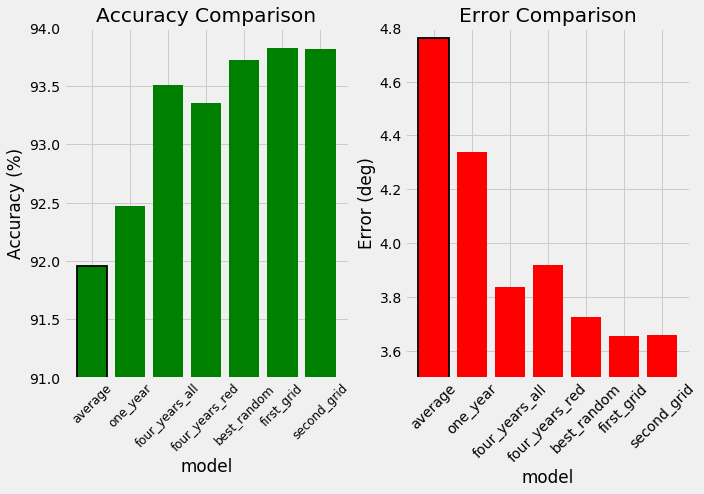

In [72]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['accuracy'], color = 'g', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45, fontsize = 12)
plt.ylim(ymin = 91, ymax = 94)
plt.xlabel('model'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['error'], color = 'r', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45)
plt.ylim(ymin = 3.5, ymax = 4.8)
plt.xlabel('model'); plt.ylabel('Error (deg)'); plt.title('Error Comparison');
plt.show();

# Training Curves
We can perform grid search over only one parameter to observe the effects of changing that parameter on performance. We will look at training time, training set accuracy, and testing set accuracy.

### Number of Trees

In [73]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.3s finished


In [74]:


tree_grid_search.cv_results_



C:\Users\Sharique Ahmed\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sharique Ahmed\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sharique Ahmed\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sharique Ahmed\Anacon

{'mean_fit_time': array([ 0.00599559,  0.04730535,  0.10760387,  0.14824796,  0.17856359,
         0.21987391,  0.39477396,  0.43042008,  0.43475064,  0.49038577,
         0.62631504,  0.68861214,  0.70193052,  0.73657648,  0.87083387,
         0.88216058,  0.79754257,  0.78754862,  0.8245275 ,  0.91165423,
         1.14551306,  1.38687094,  1.36055223,  1.32623911,  1.41768956,
         1.50831262,  1.51213352,  1.53245568,  1.6324412 ,  1.47726409]),
 'mean_score_time': array([ 0.0019985 ,  0.00266544,  0.00666388,  0.00599655,  0.01166073,
         0.01132719,  0.01898901,  0.02032145,  0.01965547,  0.02331956,
         0.03598062,  0.03731243,  0.02865012,  0.03131596,  0.0336473 ,
         0.03198139,  0.03164808,  0.03298132,  0.03631298,  0.04730654,
         0.06429704,  0.10160836,  0.05497018,  0.06129917,  0.06096697,
         0.0546356 ,  0.06529633,  0.07962092,  0.09094763,  0.04330738]),
 'mean_test_score': array([-4.67129387, -3.86287399, -3.83621744, -3.83784038, -3.81

In [75]:


def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)



C:\Users\Sharique Ahmed\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


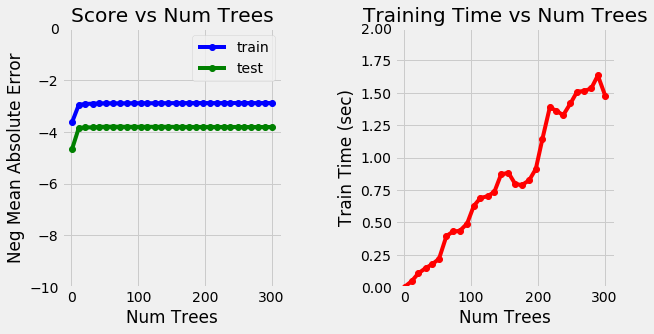

In [76]:
plot_results(tree_grid_search)

# Number of Features at Each Split

In [77]:
# Define a grid over only the maximum number of features
feature_grid = {'max_features': list(range(1, train_features.shape[1] + 1))}

In [78]:
# Create the grid search and fit on the training data
feature_grid_search = GridSearchCV(final_model, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'neg_mean_absolute_error')
feature_grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.4s finished


C:\Users\Sharique Ahmed\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


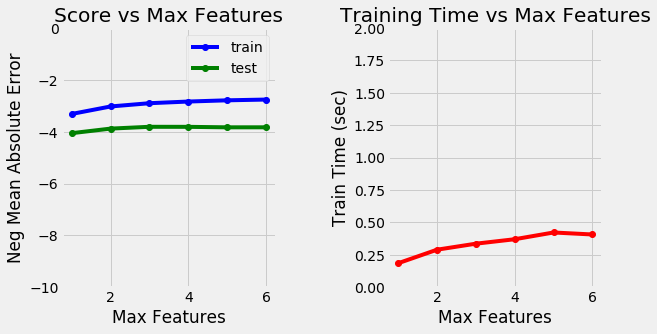

In [79]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

# Visualizing One Tree in the Forest

My favorite part about the random forest in scikit-learn may be that you can actually look at any tree in the forest. I'll pick one tree and visualize it as an image.

In [81]:
# Use sklearn to export the tree 
from sklearn.tree import export_graphviz

# # Write the decision tree as a dot file
# visual_tree = final_model.estimators_[12]
# export_graphviz(visual_tree, out_file = 'images/best_tree.dot', feature_names = important_feature_names, 
#                 precision = 2, filled = True, rounded = True, max_depth = None)